In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
class OneTarget(object):
    radiusSet=[x/2 for x in (12.92,20.23,27.55,34.86,42.18,51.39)]
    bulletSize=5.6/2

    def __init__(self,maskedImageCut,originalImageCut,contours,CROPPED_SCALED_WIDTH,angle) -> None:
        
        self.maskedImageCut = maskedImageCut.copy()
        self.originalImageCut=originalImageCut.copy()
        # filtered contours, each represent a contour
        self.contours = contours.copy()
        # min corrsponding to bullet hole
        # max corrsponding to whole target
        self.minRadius = CROPPED_SCALED_WIDTH
        self.minLocation = (0,0)
        self.maxRadius = 1
        self.maxLocation = (0,0)
        self.dist_in_rw = -1    # distance from edge to center in real world scale
        self.score=1
        self.vector = (0,0)
        self.angle = angle
        for contour in contours:
            radius,(x,y) = self.calculateCenterLocation(contour)
            if radius<self.minRadius:
                self.minRadius=radius
                self.minLocation = (x,y)
            if radius>self.maxRadius:
                self.maxRadius=radius
                self.maxLocation = (x,y)
        self.vector = (self.minLocation[0]-self.maxLocation[0],self.minLocation[1]-self.maxLocation[1])
        self.labelImage()
        self.calculateScore()

    def calculateCenterLocation(self,contour):
        # Calculate the distances to the contour
        raw_dist = np.empty(self.maskedImageCut.shape, dtype=np.float32)
        for i2 in range(self.maskedImageCut.shape[0]):
            for j2 in range(self.maskedImageCut.shape[1]):
                raw_dist[i2,j2] = cv2.pointPolygonTest(contour, (j2,i2), True)
        # 获取最大值即内接圆半径，中心点坐标
        minVal, maxVal, _, maxDistPt = cv2.minMaxLoc(raw_dist)
        minVal = abs(minVal)
        maxVal = abs(maxVal)
        radius = np.int64(maxVal)
        center=maxDistPt

        # # Used to find bullet hole center 
        # (x,y),radius = cv2.minEnclosingCircle(c)
        # M = cv2.moments(c)
        # if M['m00'] != 0:
        #     cx = int(M['m10']/M['m00'])
        #     cy = int(M['m01']/M['m00'])
        #     center = (int(cx),int(cy))
        # else:
        #     continue
        # radius = int(radius)
        return radius,center

    def labelImage(self):
        cv2.circle(self.originalImageCut,self.maxLocation,self.maxRadius,(0,255,0),2)
        cv2.circle(self.originalImageCut,self.minLocation,self.minRadius,(0,255,0),2)
        # labelling the circles around the centers, in no particular order.
        # position = (self.maxLocation[0] - 10, self.maxLocation[1] + 10)
        # text_color = (0, 0, 255)
        
        # cv2.putText(self.originalImageCut, "0", position, cv2.FONT_HERSHEY_SIMPLEX, 1, text_color, 3)
    
    def calculateScore(self):
        if (self.dist_in_rw==-1):
            dist_in_image=np.linalg.norm(np.array(self.minLocation)-np.array(self.maxLocation))
            scale=self.radiusSet[-1]/self.maxRadius
            self.dist_in_rw = round(dist_in_image*scale+self.bulletSize,3)
        # print(round(self.dist_in_rw,2))
        if (self.score==1):
            for i in range(0,-6,-1):
                if self.radiusSet[-i]>=self.dist_in_rw:
                    self.score=i
                    return self.score
            self.score=-999
            print("out of target")
        return self.score

In [3]:
def resize2Width(w,img):
    # w is the expexted width (horizontal side)
    scale_percent = w/img.shape[1] # percent of original size
    width = int(img.shape[1] * scale_percent)
    height = int(img.shape[0] * scale_percent)
    dim = (width, height)
    return cv2.resize(img,dim,interpolation = cv2.INTER_AREA) 

def simpleEllipse2Circle(img, a, b, angle,publicDegree):
    """
    args:
       img: 
       a: short diameter
       b: long diameter
       angle: rotation angle
    returns:
        
    """
    h, w = img.shape[:2]
    scale = a / b
    
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
    M[:,0:2] = np.array([[1,0],[0, scale]]) @ M[:,0:2]
   
    M[1,2] = M[1,2] * scale 
    transform = M[:, 0:2]
    circle_out = cv2.warpAffine(img, M, (w, h), borderValue=255)
    circle_out = cv2.warpAffine(circle_out, cv2.getRotationMatrix2D((w/2, h/2), -angle+publicDegree, 1), (w, h), borderValue=255)
    return circle_out

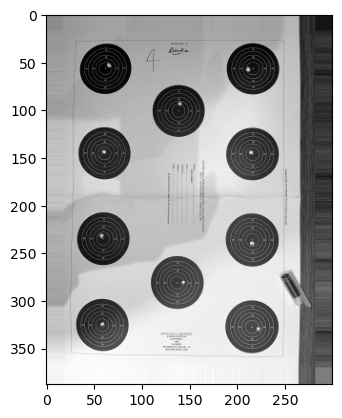

In [4]:
# image with all targets
# fileName = "02023-01-27001.jpg"
# fileName = "02023-02-18005.jpg"
# fileName = "02023-02-23011.jpg"
fileName = "02023-03-29007.jpg"
# fileName = "02023-03-31012.jpg"
originImageFileAddress = "./originImage/"
outputImageFileAddress = "./outputImage/"
img = cv2.cvtColor(cv2.imread( originImageFileAddress+ fileName),cv2.COLOR_BGR2GRAY)
coloredOriginalImage = cv2.imread( originImageFileAddress+ fileName)
if img.shape[0]<img.shape[1]:
    img = cv2.rotate(img,cv2.ROTATE_90_CLOCKWISE)
    coloredOriginalImage =  cv2.rotate(coloredOriginalImage,cv2.ROTATE_90_CLOCKWISE)
SCALED_WIDTH = 300
CROPPED_SCALED_WIDTH=300
EXTRA_RADIUS_ORIGINAL=20*(img.shape[1]//SCALED_WIDTH)
EXTRA_RADIUS=30
img=cv2.copyMakeBorder(img, EXTRA_RADIUS_ORIGINAL, EXTRA_RADIUS_ORIGINAL, EXTRA_RADIUS_ORIGINAL, EXTRA_RADIUS_ORIGINAL, cv2.BORDER_REPLICATE)
originalImg = img.copy()
originalImgSmall = resize2Width(SCALED_WIDTH,originalImg)
coloredOriginalImage = cv2.copyMakeBorder(coloredOriginalImage, EXTRA_RADIUS_ORIGINAL, EXTRA_RADIUS_ORIGINAL, EXTRA_RADIUS_ORIGINAL, EXTRA_RADIUS_ORIGINAL, cv2.BORDER_REPLICATE)
coloredOriginalImage = resize2Width(SCALED_WIDTH,coloredOriginalImage)
coloredOriginalImage = cv2.rotate(coloredOriginalImage,cv2.ROTATE_90_COUNTERCLOCKWISE)
plt.imshow(originalImgSmall,cmap="gray")

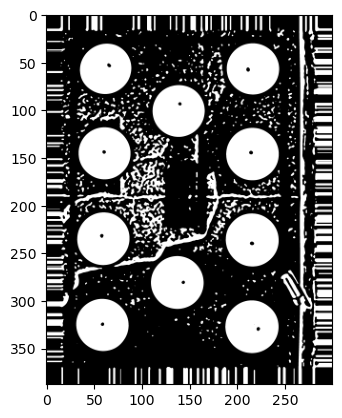

In [5]:
img_binarized = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 99, 1)
img_binarized = cv2.medianBlur(img_binarized, 25)
kernel = np.ones((5,5),np.uint8)
img_closing = cv2.morphologyEx(255-img_binarized, cv2.MORPH_CLOSE, kernel)
# # # Remove small contours
img_blured = cv2.medianBlur(img_closing, 25)
img_blured_small=resize2Width(SCALED_WIDTH,img_blured)

plt.imshow(img_blured_small,cmap="gray")

In [6]:
def getLocation(distanceCollect,height,width):
    outputIndex = []
    # left-upper and right-bottom
    temp = [x**2+y**2 for (x,y) in distanceCollect]
    index = np.argmin(temp)
    miny = distanceCollect[index][1]
    index =np.argmax(temp)
    maxy=distanceCollect[index][1]
    GAP = abs(int(maxy-miny)//8)
    if GAP==0:
        GAP==30
    for col in range(width,0,-50):
        for row in range(GAP,height+GAP,GAP):
            if len(distanceCollect)==0:
                print(outputIndex)
                return outputIndex
            for i in range(len(distanceCollect)):
                if distanceCollect[i]==False:
                    continue
                y=distanceCollect[i][0]
                x=distanceCollect[i][1]
                if x<row and y>col-50:
                    outputIndex.append(i)
                    distanceCollect[i]=False
                    break
    # print(outputIndex)
    # outputIndex = outputIndex[6:] + outputIndex[4:6] + outputIndex[0:4]
    return outputIndex

Total Num of contours detected: 736


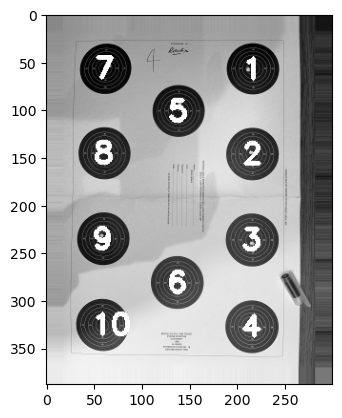

In [7]:
contours,hierarchy = cv2.findContours(img_blured_small, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
height,width = img_blured_small.shape
print("Total Num of contours detected: "+str(len(contours)))
contoursFiltered = []
newContoursFiltered = []
radiusCollect = []
distanceCollect = []
newDistanceCollect=[]
labeledPosition = []
for contour in contours:
    (x,y),radius = cv2.minEnclosingCircle(contour)
    if radius<SCALED_WIDTH*0.05:
        continue
    if np.pi*radius**2*0.8>cv2.contourArea(contour):
        continue
    contoursFiltered.append(contour)
    radiusCollect.append(radius)
    distanceCollect.append((x,y))

p1=(0,0)
p2=(0,0)
if len(radiusCollect)==0:
    pass
else:
    radiusCollect = np.array(radiusCollect)
    # print(radiusCollect)
    q75, q25 = np.percentile(radiusCollect, [75 ,25])
    iqr = q75 - q25
    iqr = max(iqr,1)
    upperBound = q75+iqr*1.5
    lowerBound = q25-iqr*1.5
    # print(upperBound,lowerBound,iqr)
    # print(upperBound,lowerBound)
    for i in range(len(contoursFiltered)):
        if (radiusCollect[i]>=lowerBound and radiusCollect[i]<=upperBound):
            newContoursFiltered.append(contoursFiltered[i])
            newDistanceCollect.append(distanceCollect[i])
    contoursFiltered=newContoursFiltered.copy()
    distanceCollect = newDistanceCollect.copy()
    
    if len(contoursFiltered)>10:
        contoursFiltered=contoursFiltered[:10]

    # print(distanceCollect)
    indexArray = getLocation(distanceCollect,height,width)
    newContoursFiltered=[]
    n=0
    
    for i in indexArray:
        (x,y),radius = cv2.minEnclosingCircle(contoursFiltered[i])
        if n==0:
            p1=(x,y)
        elif n==3:
            p2=(x,y)
        newContoursFiltered.append(contoursFiltered[i])
        center = (int(x),int(y))
        radius = int(radius)
        cv2.circle(coloredOriginalImage,(center[1],SCALED_WIDTH-center[0]),radius,(0,255,0),2)
        # labelling the circles around the centers, in no particular order.
        position = (center[0] - 10, center[1] + 10)
        text_color = (255, 255, 255)
        labeledPosition.append(position)
        plt.imshow(cv2.putText(originalImgSmall, str(n+1), position, cv2.FONT_HERSHEY_SIMPLEX, 1, text_color, 3),cmap="gray")
        if n+1==10:
            cv2.putText(coloredOriginalImage,str(n+1), (center[1] - 20,SCALED_WIDTH-center[0] + 10), cv2.FONT_HERSHEY_SIMPLEX, 1, text_color, 3)
        else:
            cv2.putText(coloredOriginalImage,str(n+1), (center[1] - 10,SCALED_WIDTH-center[0] + 10), cv2.FONT_HERSHEY_SIMPLEX, 1, text_color, 3)
        n+=1
    contoursFiltered=newContoursFiltered.copy()
# Difference in x coordinates
dx = p2[0] - p1[0]

# Difference in y coordinates
dy = p2[1] - p1[1]

# Angle between p1 and p2 in radians
if len(contoursFiltered)==10:
    # enable degree fix only if there are 10 targets.
    publicDegree =math.degrees(math.atan2(dy, dx))-90
    # print(publicDegree)
else:
    publicDegree=0

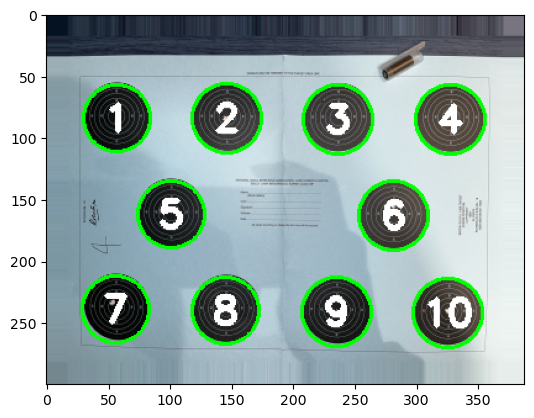

In [8]:
plt.imshow(coloredOriginalImage)

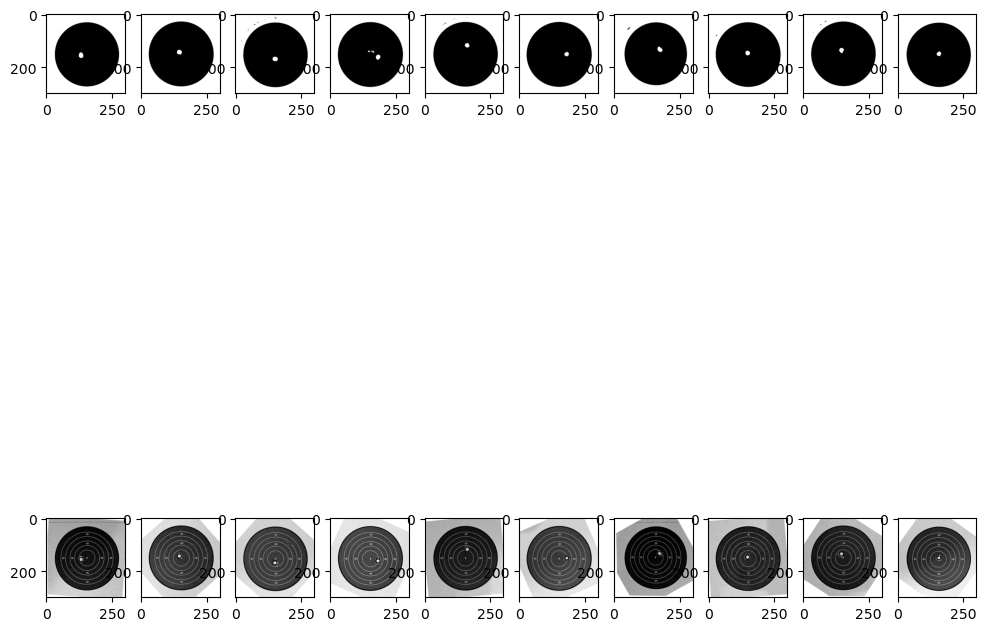

In [9]:
fig = plt.figure(figsize=(12, 12))

resultsCollection=[]
i=1
contourSize = len(contoursFiltered)
kernel = [np.ones((x,x),np.uint8) for x in (7,13,19,25,31)]
scale_percent = SCALED_WIDTH/img.shape[1]
for contour in contoursFiltered:
    
    # cut each target from full image
    (x,y),radius = cv2.minEnclosingCircle(contour)
    params = cv2.fitEllipse(contour)
    a, b = params[1]
    angle = params[2]
    mask = np.zeros(originalImg.shape[:2], dtype="uint8")
    cord_x=int(x/scale_percent)
    cord_y=int(y/scale_percent)
    radius=int(radius/scale_percent)+EXTRA_RADIUS
    
    cv2.circle(mask, (cord_x,cord_y), radius, 255, -1)
    masked = cv2.bitwise_and(255-img_closing, 255-img_closing, mask=mask)
    masked = cv2.bitwise_not(masked, masked, mask=255-mask)
    # print(cord_y-radius,cord_y+radius,cord_x-radius,cord_x+radius)
    numberOfContours=0
    kernelSwitch=0
    while numberOfContours!=2 and kernelSwitch<=4:
        originImageCut = originalImg[cord_y-radius:cord_y+radius,cord_x-radius:cord_x+radius]
        maskedCenter=masked[cord_y-radius:cord_y+radius,cord_x-radius:cord_x+radius]
        maskedCenter=cv2.copyMakeBorder(maskedCenter, EXTRA_RADIUS, EXTRA_RADIUS, EXTRA_RADIUS, EXTRA_RADIUS, cv2.BORDER_REPLICATE)
        maskedCenter =simpleEllipse2Circle(maskedCenter,a,b,angle,publicDegree)
        maskedCenter = cv2.morphologyEx(maskedCenter, cv2.MORPH_OPEN, kernel[kernelSwitch])
        maskedCenter=resize2Width(CROPPED_SCALED_WIDTH,maskedCenter)

        originImageCut=cv2.copyMakeBorder(originImageCut, EXTRA_RADIUS, EXTRA_RADIUS, EXTRA_RADIUS, EXTRA_RADIUS, cv2.BORDER_REPLICATE)
        originImageCut =simpleEllipse2Circle(originImageCut,a,b,angle,publicDegree)
        originImageCut = resize2Width(CROPPED_SCALED_WIDTH,originImageCut)

        smallContours, hierarchy = cv2.findContours(maskedCenter, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

        smallContoursFiltered = []
        for c in smallContours:
            (x_temp,y_temp),radius_temp = cv2.minEnclosingCircle(c)
            # print(x,y,radius)
            if radius_temp<CROPPED_SCALED_WIDTH*0.02 or radius_temp>CROPPED_SCALED_WIDTH*0.475 :
                continue
            if 3.14159*radius_temp**2*0.4>cv2.contourArea(c):
                continue
            smallContoursFiltered.append(c)
        numberOfContours = len(smallContoursFiltered)
        kernelSwitch+=1
    
    
    resultsCollection.append(OneTarget(maskedCenter,originImageCut,smallContoursFiltered,CROPPED_SCALED_WIDTH,angle))
    fig.add_subplot(2,contourSize,i)
    plt.imshow(maskedCenter,cmap='gray')
    # print(numberOfContours)
    
    fig.add_subplot(2,contourSize,i+contourSize)
    cv2.imwrite('{:s}{:s}_{:d}.jpg'.format(outputImageFileAddress,fileName[:-4],i), resultsCollection[i-1].originalImageCut)
    plt.imshow(resultsCollection[i-1].originalImageCut,cmap="gray")
    i+=1
plt.show()

Bullet Hole:
8
(133, 157)
Target:
120
(155, 153)


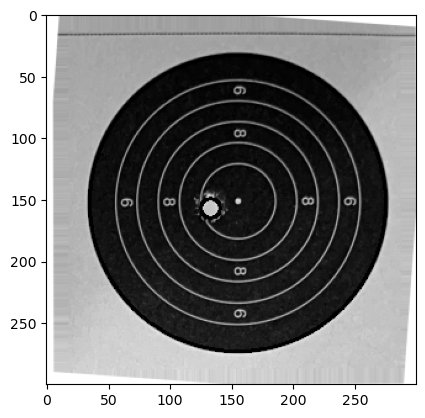

In [10]:
# View processed result for specific targets.
index = 0
plt.imshow(resultsCollection[index].originalImageCut,cmap="gray")
print("Bullet Hole:")
print(resultsCollection[index].minRadius)
print(resultsCollection[index].minLocation)
print("Target:")
print(resultsCollection[index].maxRadius)
print(resultsCollection[index].maxLocation)

Score of the target 1: 9
Score of the target 2: 10
Score of the target 3: 10
Score of the target 4: 9
Score of the target 5: 9
Score of the target 6: 9
Score of the target 7: 9
Score of the target 8: 10
Score of the target 9: 10
Score of the target 10: 10


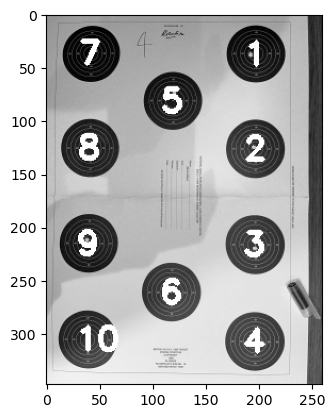

In [11]:
plt.imshow(originalImgSmall[20:-20,20:-20],cmap="gray")
index= 0
for i in resultsCollection:
    # print(i.dist_in_rw)
    print("Score of the target "+str(index+1)+": "+str(10+i.score))
    index+=1